# Forecast for Product Demand using XGBoost

In this project, we will be working with a manufacturing company's historical product demand data to perform exploratory data analysis (EDA) and create a forecast using Python.

The primary goal of this project is to gain insights into the data and identify patterns and trends in product demand that could help the manufacturing company make informed decisions about production planning and inventory management. We will be using various statistical and data visualization techniques to perform EDA on the data.

Once we have a better understanding of the data, we will be using time series analysis techniques to create a forecast of product demand. The forecast will help the manufacturing company make informed decisions about production planning, inventory management, and resource allocation.

The project will be implemented using the Python programming language and the following libraries: pandas, numpy, matplotlib, and prohpet. The data used in this project is from [Kaggle](https://www.kaggle.com/datasets/felixzhao/productdemandforecasting).

Overall, this project aims to provide a comprehensive analysis of the historical product demand data and create a forecast that can help the manufacturing company optimize their operations and improve their bottom line.

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

path = 'Historical Product Demand.csv'

df = pd.read_csv(path)

df.head()


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [93]:
df.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


### Data Cleaning
Before starting any analysis, it is important to ensure that the data is clean and ready for analysis. This includes removing duplicates, filling missing values, and correcting any errors.

In [95]:
#Check for duplicated values
print(df.duplicated().sum())

122423


In [96]:
#Deleting duplicated values
df = df.drop_duplicates()

print(df.duplicated().sum())


0


In [97]:
#Checking for null values
df.isnull().sum()

Product_Code           0
Warehouse              0
Product_Category       0
Date                1880
Order_Demand           0
dtype: int64

In [98]:
#Dropping null values
df = df.dropna()

df.isnull().sum()


Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [99]:
df.info()

#Still need to change data types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924272 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Product_Code      924272 non-null  object
 1   Warehouse         924272 non-null  object
 2   Product_Category  924272 non-null  object
 3   Date              924272 non-null  object
 4   Order_Demand      924272 non-null  object
dtypes: object(5)
memory usage: 42.3+ MB


In [100]:
#Changing the Date column to datetime Dtype
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M:%S')
#Changing order demand column to numeric had to use 'coerce' because data contained strings
df.Order_Demand = pd.to_numeric(df.Order_Demand, errors='coerce')

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 924272 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Product_Code      924272 non-null  object        
 1   Warehouse         924272 non-null  object        
 2   Product_Category  924272 non-null  object        
 3   Date              924272 non-null  datetime64[ns]
 4   Order_Demand      918468 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 42.3+ MB


In [101]:
#Dropping rows with NaN in data caused by changing order demand Dtype
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918468 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Product_Code      918468 non-null  object        
 1   Warehouse         918468 non-null  object        
 2   Product_Category  918468 non-null  object        
 3   Date              918468 non-null  datetime64[ns]
 4   Order_Demand      918468 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 42.0+ MB


In [102]:
#Change dtype from float to int
df.Order_Demand = df.Order_Demand.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918468 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Product_Code      918468 non-null  object        
 1   Warehouse         918468 non-null  object        
 2   Product_Category  918468 non-null  object        
 3   Date              918468 non-null  datetime64[ns]
 4   Order_Demand      918468 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(3)
memory usage: 38.5+ MB


In [103]:
# Removing rows where order demand is 0
df = df.query('Order_Demand > 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898829 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Product_Code      898829 non-null  object        
 1   Warehouse         898829 non-null  object        
 2   Product_Category  898829 non-null  object        
 3   Date              898829 non-null  datetime64[ns]
 4   Order_Demand      898829 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(3)
memory usage: 37.7+ MB


### Exploratory Data Analysis (EDA)
 The first step in any analysis is to understand the data. EDA can be done by looking at the distribution of data, identifying outliers, checking for trends, and examining the relationships between variables. We will be looking at the overall demand trend, demand by warehouse, demand by product category, and demand by product code.

Overall demand trend: 
By plotting the total order demand over time, we can identify if there are any seasonal patterns or if there has been a significant change in demand over time.

<AxesSubplot:xlabel='Date'>

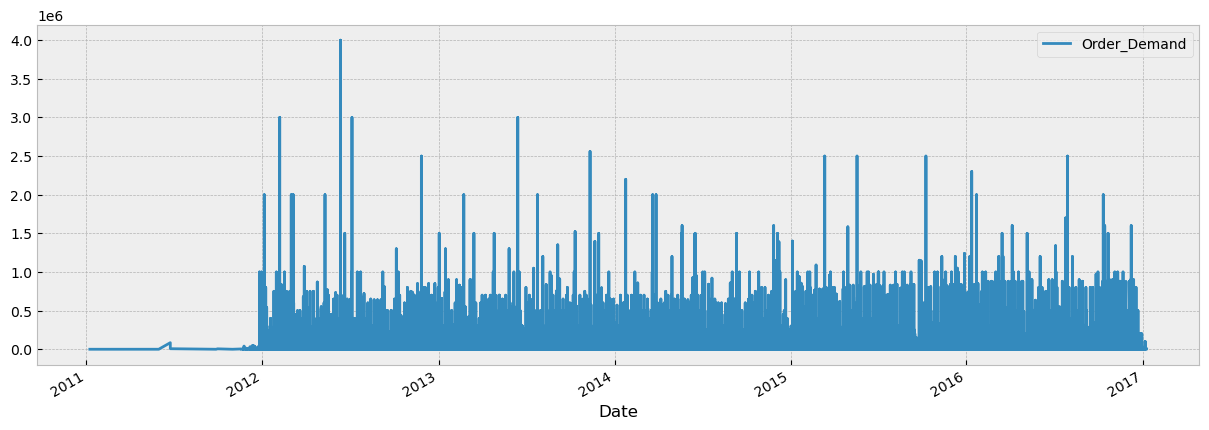

In [104]:
df.plot(x='Date', y='Order_Demand',figsize=(15,5))

### Demand by warehouse 
Analyzing the demand for each warehouse can help identify any regional differences in demand.

In [105]:
# Gives top 10 desc info on order demand
def top_demand_info(category: str):
    return df.groupby(by=category)['Order_Demand']\
        .sum().nlargest(10)

top_demand_info('Warehouse')

Warehouse
Whse_J    2.992522e+09
Whse_S    1.020226e+09
Whse_C    5.611326e+08
Whse_A    1.433242e+08
Name: Order_Demand, dtype: float64

<AxesSubplot:ylabel='Warehouse'>

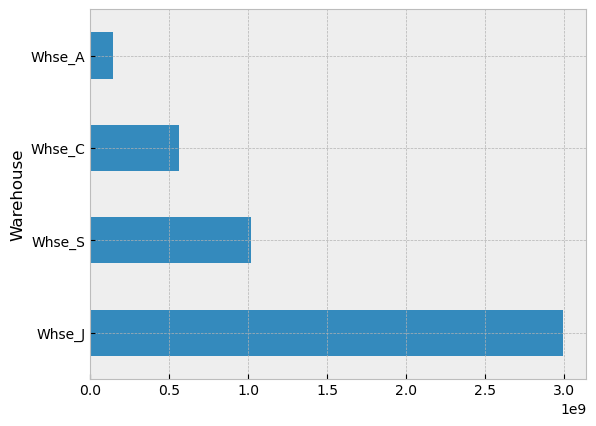

In [106]:
# Graph top 10 desc of category entered
def top_demand_graph(category: str):
    return df.groupby(by=category)['Order_Demand']\
        .sum().nlargest(10,)\
        .plot.barh()

top_demand_graph('Warehouse')

### Demand by product category
Examining the demand for each product category can help identify which categories have the highest demand and which ones are not performing as well.

In [107]:
top_demand_info('Product_Category')

Product_Category
Category_019    3.858939e+09
Category_006    3.926149e+08
Category_005    1.889608e+08
Category_007    1.220730e+08
Category_028    4.751542e+07
Category_033    4.068000e+07
Category_030    3.979790e+07
Category_021    4.352875e+06
Category_032    4.320086e+06
Category_009    3.656350e+06
Name: Order_Demand, dtype: float64

<AxesSubplot:ylabel='Product_Category'>

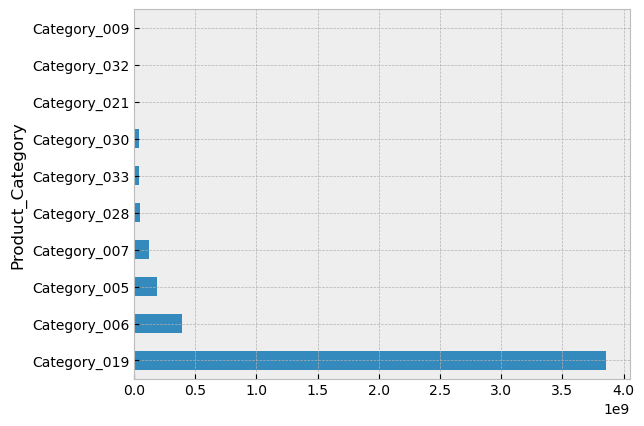

In [108]:
top_demand_graph('Product_Category')


In [109]:
# Gives bottom 10 desc info on order demand
def lowest_demand_info(category: str):
    return df.groupby(by=category)['Order_Demand']\
        .sum().nsmallest(10)


lowest_demand_info('Product_Category')


Product_Category
Category_027       80.0
Category_014      100.0
Category_002      620.0
Category_031    12617.0
Category_016    16850.0
Category_008    17325.0
Category_010    19280.0
Category_029    22429.0
Category_018    44747.0
Category_017    47095.0
Name: Order_Demand, dtype: float64

<AxesSubplot:ylabel='Product_Category'>

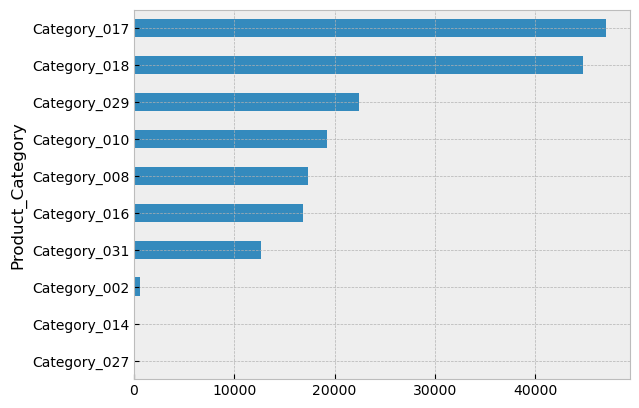

In [110]:
# Graph bottom 10 desc of category entered
def lowest_demand_graph(category: str):
    return df.groupby(by=category)['Order_Demand']\
        .sum().nsmallest(10)\
        .plot.barh()


lowest_demand_graph('Product_Category')

### Demand by product code
Examining the demand for each product code can help identify which products are the most popular and which ones are not selling well.

In [111]:
top_demand_info('Product_Code')

Product_Code
Product_1359    396260000
Product_1248    267517000
Product_0083    209191000
Product_1341    163874000
Product_1241    111873000
Product_1432     95966000
Product_1295     91029700
Product_1245     84877000
Product_1451     84669000
Product_1274     80994000
Name: Order_Demand, dtype: int32

<AxesSubplot:ylabel='Product_Code'>

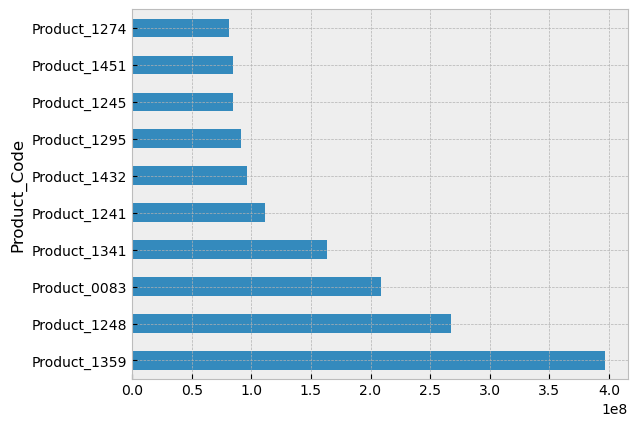

In [112]:
top_demand_graph('Product_Code')


In [113]:
lowest_demand_info('Product_Code')

Product_Code
Product_1698     2
Product_1703     2
Product_0465     3
Product_0638    20
Product_0853    20
Product_1863    21
Product_0466    23
Product_1793    26
Product_0633    27
Product_0647    27
Name: Order_Demand, dtype: int32

<AxesSubplot:ylabel='Product_Code'>

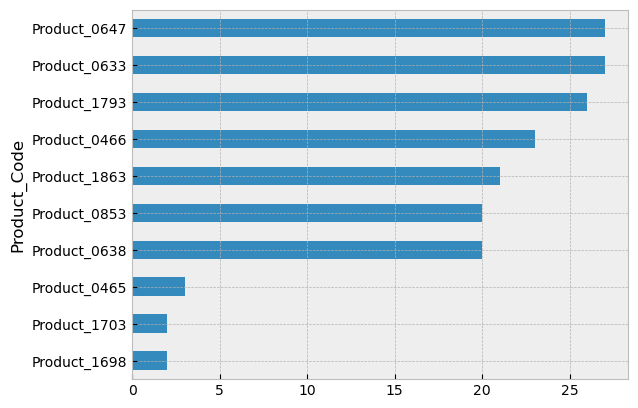

In [114]:
lowest_demand_graph('Product_Code')

### Feature Engineering
Feature engineering involves creating new features from the existing data that can provide additional information and insights. By including things like, lag features and moving average, we are taking into account the time-dependent relationships between variables and improving the accuracy of our forecasts. The moving average is a baseline model to compare the performance of other forecasting methods. We can also use the moving average as a component in more complex forecasting models.

In [115]:
#Lag features and Moving Average

# sort the data by Date in ascending order
df = df.sort_values(by='Date')

# calculate a 7-day moving average of Order_Demand
df['Order_Demand_MA7'] = df['Order_Demand'].rolling(window=7).mean()

# create a new column with a 7-day lag of Order_Demand
df['Order_Demand_lag7'] = df['Order_Demand'].shift(7)

# drop any rows with missing values
df = df.dropna()

df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Order_Demand_MA7,Order_Demand_lag7
74615,Product_0875,Whse_C,Category_023,2011-09-30,5450,14119.428571,2.0
75193,Product_0642,Whse_C,Category_019,2011-10-31,3,14104.428571,108.0
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000,2533.000000,85000.0
44795,Product_0965,Whse_A,Category_006,2011-11-18,1,1533.142857,7000.0
44796,Product_0965,Whse_A,Category_006,2011-11-21,3,1355.000000,1250.0
...,...,...,...,...,...,...,...
920149,Product_0025,Whse_J,Category_005,2017-01-06,400,15657.857143,15.0
920154,Product_0025,Whse_J,Category_005,2017-01-06,700,14615.000000,8000.0
908844,Product_0471,Whse_C,Category_015,2017-01-09,30,14618.857143,3.0
908447,Product_0250,Whse_C,Category_007,2017-01-09,148,354.285714,100000.0


In [116]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Order_Demand_MA7'] = df['Order_Demand_MA7'].astype(int)
    df['Order_Demand_lag7'] = df['Order_Demand_lag7'].astype(int)

    X = df[['dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekofyear', 'Order_Demand_MA7', 'Order_Demand_lag7','Order_Demand']]
    if label:
        y = df[label]
        return X, y
    return X


X, y = create_features(df, 'Order_Demand')

features = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','Order_Demand_MA7','Order_Demand_lag7']
target = 'Order_Demand'

features_and_target = pd.concat([X, y], axis=1)

# See our features and target
features_and_target.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Order_Demand_MA7,Order_Demand_lag7,Order_Demand,Order_Demand
74615,4,3,9,2011,273,30,39,14119,2,5450,5450
75193,0,4,10,2011,304,31,44,14104,108,3,3
44450,4,4,11,2011,322,18,46,2533,85000,4000,4000
44795,4,4,11,2011,322,18,46,1533,7000,1,1
44796,0,4,11,2011,325,21,47,1355,1250,3,3


### Modeling
After exploring the data it's time to develop a forecasting model. There are many modeling techniques that can be used for time series forecasting, but we will be using XGBoost.

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898822 entries, 74615 to 863020
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Product_Code       898822 non-null  object        
 1   Warehouse          898822 non-null  object        
 2   Product_Category   898822 non-null  object        
 3   Date               898822 non-null  datetime64[ns]
 4   Order_Demand       898822 non-null  int32         
 5   Order_Demand_MA7   898822 non-null  float64       
 6   Order_Demand_lag7  898822 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), object(3)
memory usage: 51.4+ MB


In [118]:
# Test/Train Split
split_date = '01-01-2016'
train = df[df['Date'] < pd.Timestamp(split_date)]
test = df[df['Date'] >= pd.Timestamp(split_date)]

train = create_features(train)
test = create_features(test)


In [119]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [120]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01)

# fit the model
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50, early_stopping_rounds=50)


[0]	validation_0-rmse:30800.84833	validation_1-rmse:32892.62043


c:\Users\kemo8\miniconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-rmse:28380.59911	validation_1-rmse:31030.74810
[100]	validation_0-rmse:27363.09765	validation_1-rmse:30368.98798
[150]	validation_0-rmse:26786.90449	validation_1-rmse:30192.51171
[200]	validation_0-rmse:26371.24069	validation_1-rmse:30199.07630
[210]	validation_0-rmse:26319.65445	validation_1-rmse:30192.59930


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot:>

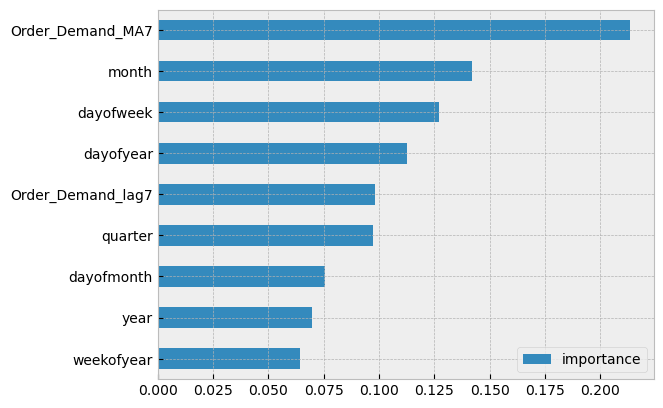

In [121]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

fi.sort_values('importance').plot.barh()

In [122]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Order_Demand_MA7,Order_Demand_lag7,prediction
74615,Product_0875,Whse_C,Category_023,2011-09-30,5450,14119.428571,2.0,NaN
75193,Product_0642,Whse_C,Category_019,2011-10-31,3,14104.428571,108.0,NaN
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000,2533.000000,85000.0,NaN
44795,Product_0965,Whse_A,Category_006,2011-11-18,1,1533.142857,7000.0,NaN
44796,Product_0965,Whse_A,Category_006,2011-11-21,3,1355.000000,1250.0,NaN
...,...,...,...,...,...,...,...,...
920149,Product_0025,Whse_J,Category_005,2017-01-06,400,15657.857143,15.0,12498.639648
920154,Product_0025,Whse_J,Category_005,2017-01-06,700,14615.000000,8000.0,12498.639648
908844,Product_0471,Whse_C,Category_015,2017-01-09,30,14618.857143,3.0,12498.639648
908447,Product_0250,Whse_C,Category_007,2017-01-09,148,354.285714,100000.0,290.973938


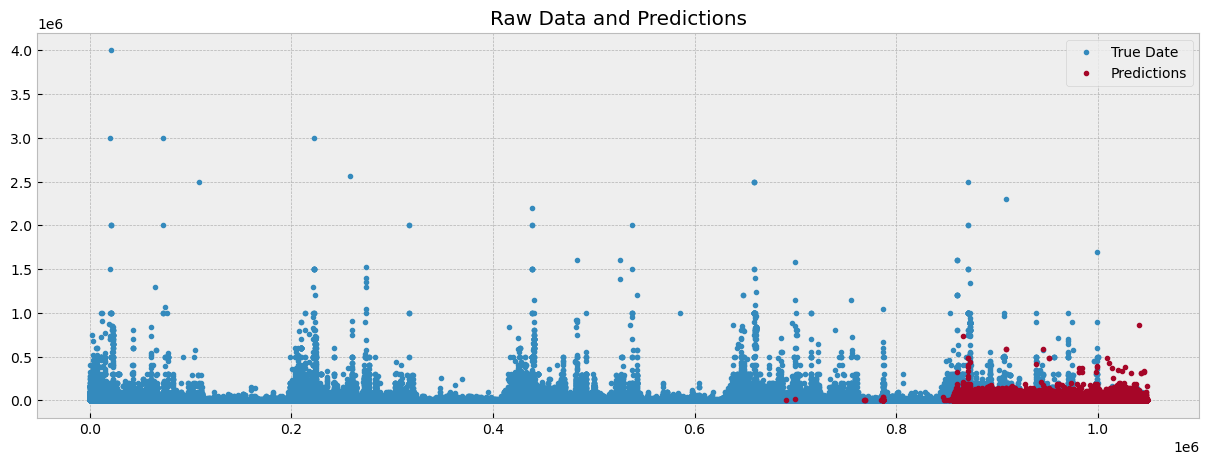

In [123]:
ax = df[['Order_Demand']].plot(figsize=(15, 5),style='.')
df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Date', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()


### Model Evaluation
After building the model, it's important to evaluate its performance on a test set. This can be done by calculating metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).